# 2D Wave Equation Modeling Using PINNs - Data fitting
The goal of this notebook is to use a Physics-Informed Neural Net (PINN) to predict the seismic wavefield generated by a point source in a 2D acoustic isotropic medium with **constant velocity**. 

## Outline
- We create a neural net which takes into input the position $x,y$ and the time $t$. The output is the acoustic pressure $p(x,y,t)$ at this location/time
- For the training stage, **we only use one constraint**, the data-fitting term:
    - We generate seismic data with a FD scheme
    - We record a subset of this data (10 snapshots every 0.4 s with a spatial sampling of 20 m in both directions), which we use as training data for the NN
- We compare the **PINN solution** with the numercial solution obtained using a **finite-difference (FD)** scheme  

## Finite-difference solution

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Flag for QC
want_qc = 0

########################## Spatial sampling ##########################
# Spatial sampling
dx = 0.01; dx2 = dx*dx; x0 = 0; x1 = 2; nx_pad = 50; x0_pad = x0 - nx_pad*dx; x1_pad = x1 + dx*nx_pad
dy = 0.01; dz2= dy*dy; y0 = 0; y1 = 1; ny_pad=50; y0_pad = y0 - ny_pad*dy; y1_pad = y1 + dy*ny_pad
x = np.arange(x0_pad, x1_pad+dx, dx) # use linspace
y = np.arange(y0_pad, y1_pad+dy, dy) # use linspace
nx = x.shape[0]
ny = y.shape[0]
ny_small = ny-2*ny_pad
nx_small = nx-2*nx_pad
x_small = x[nx_pad:nx_pad+nx_small]
y_small = y[ny_pad:ny_pad+ny_small]

# Remarks:
# nx/ny are the dimensions of the modeling domain, which includes the absorbing boundaries (i.e., the "sponge")
# nx_small/ny_small are the dimensions of the domain of interest

########## QC ##########
if want_qc:
    print("-"*20)
    print("x0: ", x[0], ", dx: ", dx, ", x1: ", x[nx-1], ", nx: ", nx)
    print("x0 eff: ", x_small[0], ", dx: ", dx, ", x1 eff: ", x_small[nx_small-1], ", nx eff: ", nx_small)
    print("y0: ", y[0], ", dy: ", dy, ", y1: ", y[ny-1], ", ny: ", ny)
    print("y0 eff: ", y_small[0], ", dy: ", dy, ", y1 eff: ", y_small[ny_small-1], ", ny eff: ", ny_small)
    print("-"*20)
########################

########################## Damping mask ##############################
damp_mask = np.zeros((nx,ny))+1.0
min_pad = min(ny_pad, nx_pad)
alpha_cos = 0.99
damp_filter = np.zeros((min_pad))

for i_filter in range(min_pad):
    arg = np.pi / (1.0*min_pad) * (min_pad-i_filter)
    arg = alpha_cos + (1.0-alpha_cos) * np.cos(arg)
    damp_filter[i_filter] = arg

for ix in range(0, nx):
    for iy in range(0, ny):
        dist2edge = min(ix, iy, ny-iy-1, nx-ix-1)
        if dist2edge < min_pad:
            damp_mask[ix,iy] = damp_filter[dist2edge]

########## QC ##########
if want_qc:
    print("-"*20)
    # print("damp_mask y: ", damp_mask[nx_pad+nx_small,ny_pad:ny_pad+ny_small])
    print("damp_mask shape y: ", damp_mask[nx_pad+nx_small,ny_pad:ny_pad+ny_small].shape)
    # print("damp_mask x: ", damp_mask[nx_pad:nx_pad+nx_small,ny_pad+ny_small])
    print("damp_mask shape x: ", damp_mask[nx_pad:nx_pad+nx_small,ny_pad+ny_small].shape)
    print("-"*20)
########################

############################ Time sampling ###########################
dt = 0.001; dt2 = dt*dt; t0 = 0; t1 = 2
t = np.arange(t0, t1+dt, dt)
nt = t.shape[0]

########## QC ##########
if want_qc:
    print("-"*20)
    print("t0: ", t[0], ", t1: ", t[nt-1], ", dt: ", dt, ", nt: ", nt)
    print("-"*20)
########################

############################## Velocity #############################
# Use a constant velocity
c=1.5
    
######################## Allocate wavefields ##########################
p = np.zeros((nt,nx,ny))

# Allocation for training dataset 
x_data = np.zeros((nt,nx,ny))
y_data = np.zeros((nt,nx,ny))
t_data = np.zeros((nt,nx,ny))

# T,X,Y shape: (nt, nx, ny)
T,X,Y = np.meshgrid(t, x[nx_pad:nx-nx_pad], y[ny_pad:ny-ny_pad])
T = T.swapaxes(0,1)
X = X.swapaxes(0,1)
Y = Y.swapaxes(0,1)
P = np.zeros(X.shape)

########## QC ##########
if want_qc:
    print("T shape: ", T.shape)
    print("X shape: ", X.shape)
    print("Y shape: ", Y.shape)
    print("P shape: ", P.shape)
    print("X: ", X[0,:,0].shape)
    print("Y: ", Y[0,0,:].shape)
    print("T: ", T[:,0,0].shape)

######################## Create Ricker wavelet #######################
# Generate wavelet in time
fDom=10
fmax=32
alpha=(np.pi*fDom)**2
source = np.zeros(nt)
timeDelay=0.12
for it in range(nt):
    time1=it*dt
    time1=time1-timeDelay
    source[it]=(1-2.0*alpha*time1*time1)*np.exp(-1.0*alpha*time1*time1)

# Scale the source
source *= 1e5
    
# Source position    
ixSource = nx//2
iySource = ny//2

########## QC ##########
if want_qc:
    print("Source ix: ", ixSource, ", source iy: ", iySource)
    print("Source x: ", x[ixSource], ", source y: ", y[iySource])
    print("alpha: ", alpha)
########################

# Compute source spetrcum
sourceFft = np.fft.fft(source)
freq = np.fft.fftfreq(nt, dt)
nFreq = nt/2
nFreq=int(nFreq)

########################### Display info #############################
if want_qc:
    # Spatial/temporal parameters
    print("nx:", nx, ", x0:", x0_pad, ", x1:", x[nx-1], "dx:", dx)
    print("ny:", ny, ", y0:", y0_pad, ", y1:", y[ny-1], "dy:", dy)
    print("nt:", nt, ", t0:", t0, ", t1:", t1, ", dt:", dt)
    print("nx small:", nx_small, ", x0:", x0, ", x1:", x[nx-1-nx_pad], "dx:", dx)
    print("ny small:", ny_small, ", y0:", y0, ", y1:", y[ny-1-ny_pad], "dy:", dy)
######################################################################

# FD parameters
courant = c*dt/dx
disp = c/(dt*fmax)
if want_qc:
    print("Courant:" , courant)
    print("Dispersion:" , disp)

## 
print("--- Done ---")

--- Done ---


## Propagate and save wavefield

In [3]:
############################# Propagate and save wavefield ##############################
# Loop over time
for it in range(2, nt):
    
    # Step forward in time
    p[it,1:-1,1:-1] = 2*p[it-1,1:-1,1:-1] - p[it-2,1:-1,1:-1] + (c**2)*((dt/dx)**2) * (p[it-1,2:,1:-1] - 2*p[it-1,1:-1,1:-1] + p[it-1,0:-2,1:-1]) + (c**2)*((dt/dy)**2) * (p[it-1,1:-1,2:] - 2*p[it-1,1:-1,1:-1] + p[it-1,1:-1,0:-2])    
    
    # Inject source
    p[it,ixSource,iySource] += (dt**2)*(c**2)*source[it-1]  
    
    # Apply cosine taper
    p[it,:,:] *= damp_mask
    p[it-1,:,:] *= damp_mask

# Record data - Correct scaling
P = p[:,nx_pad:nx-nx_pad,ny_pad:ny-ny_pad]

# Extract subset for training data
train_sub = 2
P_train = P[:,::train_sub,::train_sub]
T_train = T[:,::train_sub,::train_sub]
X_train = X[:,::train_sub,::train_sub]
Y_train = Y[:,::train_sub,::train_sub]
nx_train = P_train.shape[1]
ny_train = P_train.shape[2]

# FD solution to compare with PINN inference
pinn_sub = 2
P_sub = P[:,::pinn_sub,::pinn_sub]
T_sub = T[:,::pinn_sub,::pinn_sub]
X_sub = X[:,::pinn_sub,::pinn_sub]
Y_sub = Y[:,::pinn_sub,::pinn_sub]
nx_infer = P_sub.shape[1]
ny_infer = P_sub.shape[2]

########## QC ##########
if want_qc:
    print("P shape: ", P.shape)
    print("P sub: ", P_sub.shape)
    print("nx infer", nx_infer)
    print("ny infer", ny_infer)
    print("P train: ", P_train.shape)   
    print("nx train", nx_train)
    print("ny train", ny_train)    
########################

print("--- Done ---")

--- Done ---


## Plot source 

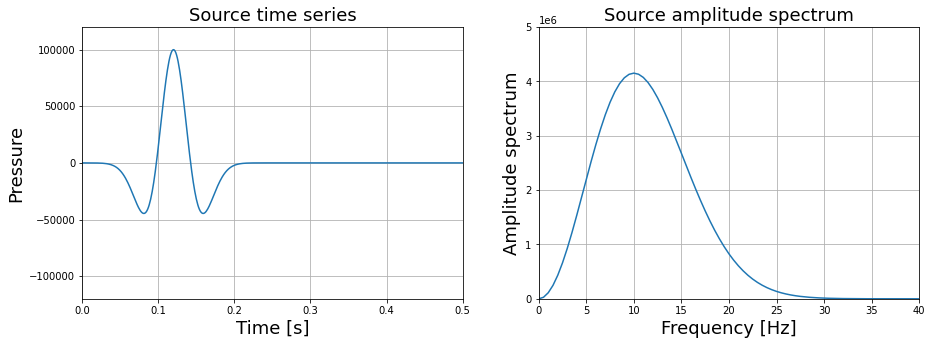

In [4]:
################## Source ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot source time series 
img2 = axs[0].plot(t, source)
axs[0].set_xlabel('Time [s]', fontsize=18)
axs[0].set_ylabel('Pressure', fontsize=18)
axs[0].set_title('Source time series', fontsize=18)
axs[0].set_xlim(0,0.5)
axs[0].set_ylim([-1.2e5, 1.2e5])
axs[0].grid()

# Plot source time series 
img2 = axs[1].plot(freq[:nFreq], np.abs(sourceFft[:nFreq]))
axs[1].set_xlabel('Frequency [Hz]', fontsize=18)
axs[1].set_ylabel('Amplitude spectrum', fontsize=18)
axs[1].set_title('Source amplitude spectrum', fontsize=18)
axs[1].set_xlim(0,40)
axs[1].set_ylim([0, 0.5e7])
axs[1].grid()

# Save figure
plt.savefig("we-fwd-2d-cv-snapshots-source.png")


## Plot FD solution

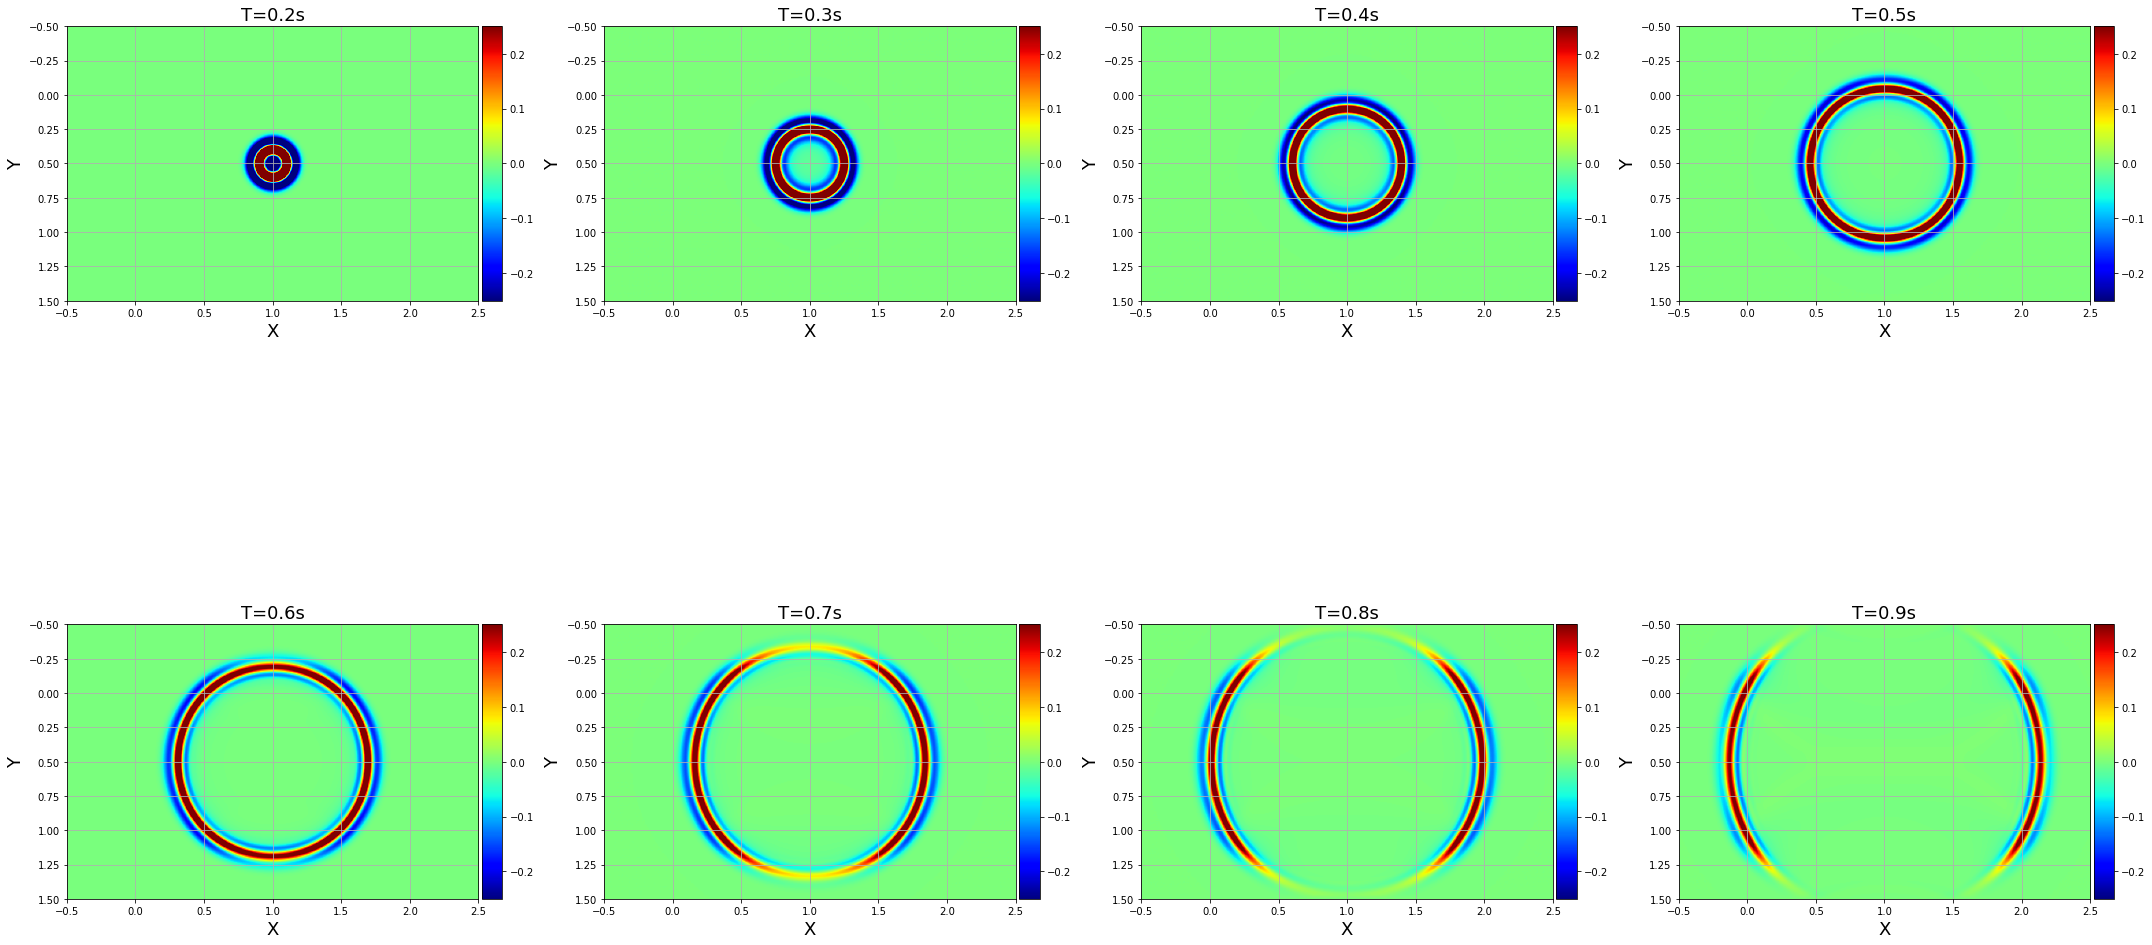

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

################## Plotting ##################
# Plotting the FD solution (each figure includes the absorbing boundaries)
# Create figures and axes
fig, axs = plt.subplots(2, 4, figsize=(30, 30))

# Select snapshot time
time0=0.2; time1=0.3; time2=0.4; time3=0.5
time4=0.6; time5=0.7; time6=0.8; time7=0.9
it0 = np.argmin(abs(time0-t))
it1 = np.argmin(abs(time1-t))
it2 = np.argmin(abs(time2-t))
it3 = np.argmin(abs(time3-t))
it4 = np.argmin(abs(time4-t))
it5 = np.argmin(abs(time5-t))
it6 = np.argmin(abs(time6-t))
it7 = np.argmin(abs(time7-t))

p_min=-0.25; p_max=0.25
xmin = x[nx_pad]; xmax = x[nx-nx_pad-1]
ymax = y[ny_pad]; ymin = y[ny-ny_pad-1]

# QC values
if want_qc:
    print("p max: ", p.max())
    print("p min: ", p.min())
    print("xmin: ", xmin)
    print("xmax: ", xmax)
    print("ymin: ", ymin)
    print("ymax: ", ymax)

x0p=x.min(); x1p=x.max()
y0p=y.min(); y1p=y.max()

# FD solution
img0 = axs[0,0].imshow(p[it0,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0,0].set_xlabel('X', fontsize=18)
axs[0,0].set_ylabel('Y', fontsize=18)
axs[0,0].set_title('T='+str(time0)+'s', fontsize=18)
axs[0,0].grid()
plt.tight_layout()

img0 = axs[0,1].imshow(p[it1,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0,1].set_xlabel('X', fontsize=18)
axs[0,1].set_ylabel('Y', fontsize=18)
axs[0,1].set_title('T='+str(time1)+'s', fontsize=18)
axs[0,1].grid()
plt.tight_layout()

img0 = axs[0,2].imshow(p[it2,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0,2].set_xlabel('X', fontsize=18)
axs[0,2].set_ylabel('Y', fontsize=18)
axs[0,2].set_title('T='+str(time2)+'s', fontsize=18)
axs[0,2].grid()
plt.tight_layout()

img0 = axs[0,3].imshow(p[it3,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0,3].set_xlabel('X', fontsize=18)
axs[0,3].set_ylabel('Y', fontsize=18)
axs[0,3].set_title('T='+str(time3)+'s', fontsize=18)
axs[0,3].grid()
plt.tight_layout()

img0 = axs[1,0].imshow(p[it4,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1,0].set_xlabel('X', fontsize=18)
axs[1,0].set_ylabel('Y', fontsize=18)
axs[1,0].set_title('T='+str(time4)+'s', fontsize=18)
axs[1,0].grid()
plt.tight_layout()

img0 = axs[1,1].imshow(p[it5,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1,1].set_xlabel('X', fontsize=18)
axs[1,1].set_ylabel('Y', fontsize=18)
axs[1,1].set_title('T='+str(time5)+'s', fontsize=18)
axs[1,1].grid()
plt.tight_layout()

img0 = axs[1,2].imshow(p[it6,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1,2].set_xlabel('X', fontsize=18)
axs[1,2].set_ylabel('Y', fontsize=18)
axs[1,2].set_title('T='+str(time6)+'s', fontsize=18)
axs[1,2].grid()
plt.tight_layout()

img0 = axs[1,3].imshow(p[it7,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(x0p, x1p, y1p, y0p))
divider = make_axes_locatable(axs[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1,3].set_xlabel('X', fontsize=18)
axs[1,3].set_ylabel('Y', fontsize=18)
axs[1,3].set_title('T='+str(time7)+'s', fontsize=18)
axs[1,3].grid()
plt.tight_layout()
 
######################### Wavefield ##############################    
# for i in range(0, nt, 100):
#     print("i: ", i)
#     plt.imshow(p[i,:,:], cmap='jet', vmin=p.min(), vmax=p.max())
#     plt.title(i)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)    
#     time.sleep(1)
##################################################################

# Save figure
plt.savefig("we-fwd-2d-cv-snapshots-fd-pressure.png")


## Save dataset for training

Generating snapshots for training data for t:  [0.2        0.24444444 0.28888889 0.33333333 0.37777778 0.42222222
 0.46666667 0.51111111 0.55555556 0.6       ]
Statistics P_data max:  0.96306758916043 , P_data min:  -0.44004594487736937 , P_data mean:  0.0007698481292569408 , P_data stdv:  0.11109909394571288
--- Saving dataset ---
P shape:  (2001, 201, 101)
Number of training samples:  51510
--- Done ---


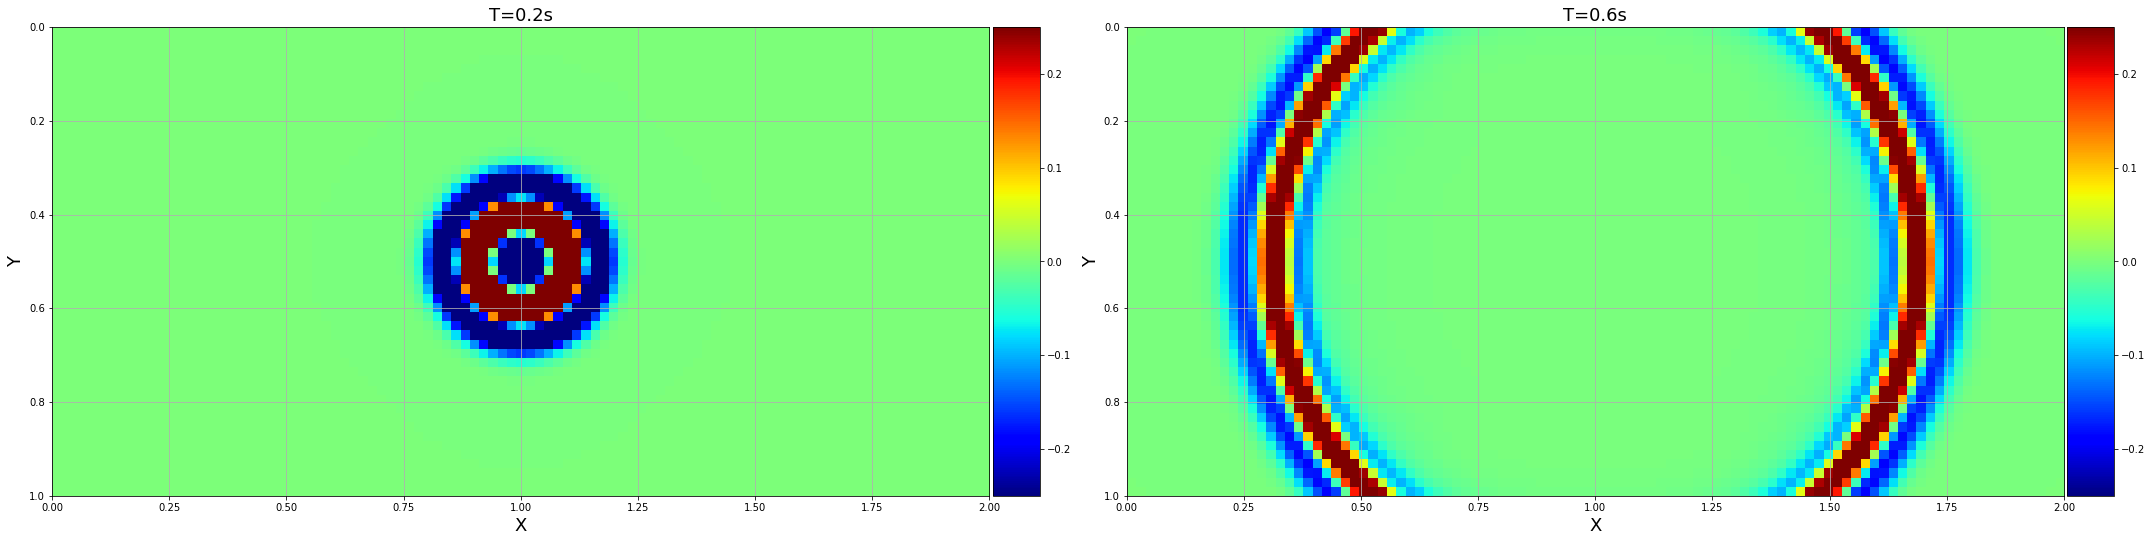

In [6]:
import h5py
import os

# Choose time slices to record
n_snap = 10
t_init = 0.2
t_final = 0.6
rec_time = np.linspace(t_init, t_final, n_snap)
# For training, we choose to use 10 snapshots regularly sampled between 0.2 s and 0.6 s

# Allocate data arrays
T_data = np.zeros((n_snap, nx_train, ny_train))
X_data = np.zeros((n_snap, nx_train, ny_train))
Y_data = np.zeros((n_snap, nx_train, ny_train))
P_data = np.zeros((n_snap, nx_train, ny_train))

############ QC ############
print("Generating snapshots for training data for t: ", rec_time)
############################

# Generate data
for it in range(n_snap):
    index = np.argmin(abs(rec_time[it]-t))
    P_data[it,:,:] = P_train[index,:,:]
    T_data[it,:,:] = T_train[index,:,:]
    X_data[it,:,:] = X_train[index,:,:]
    Y_data[it,:,:] = Y_train[index,:,:]

# QC    
if want_qc:
    print("it: ", 0)
    print("P_data[it,:,:]: ", P_data[it,:,:])
    print("T_data[it,:,:]: ", T_data[it,:,:])
    print("X_data[it,:,:]: ", X_data[it,:,:])
    print("Y_data[it,:,:]: ", Y_data[it,:,:])
        
# Plot
fig, axs = plt.subplots(1, 2, figsize=(30, 30))
img0 = axs[0].imshow(P_data[0,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Y', fontsize=18)
axs[0].set_title('T='+str(rec_time[0])+'s', fontsize=18)
axs[0].grid()
plt.tight_layout()

img0 = axs[1].imshow(P_data[n_snap-1,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Y', fontsize=18)
axs[1].set_title('T='+str(rec_time[n_snap-1])+'s', fontsize=18)
axs[1].grid()
plt.tight_layout()

## QC - statistics
if want_qc:
    print("T_data max/min: ", T_data.max(), T_data.min())
    print("P_data max/min/mean/median/std dev: ", P_data.max(), P_data.min(), P_data.mean(), np.median(P_data), P_data.std())
    print("X_data max/min: ", X_data.max(), X_data.min())
    print("Y_data max/min: ", Y_data.max(), Y_data.min())
    print("size: ", n_snap*nx_small*ny_small)
    print("P shape: ", P.shape)

######################### Save dataset #########################
# Correct scaling
print("Statistics P_data max: ", P_data.max(), ", P_data min: ", P_data.min(), ", P_data mean: ", P_data.mean(), ", P_data stdv: ", P_data.std())

data_fd = {}
data_fd['t'] = T_data.reshape(-1,1)
data_fd['x'] = X_data.reshape(-1,1)
data_fd['y'] = Y_data.reshape(-1,1)
data_fd['pressure'] = P_data.reshape(-1,1)

# Save data to disk
print("--- Saving dataset ---")
filename=f"data_fd_wave-2d-snapshots-n{n_snap}-ti-{t_init}-tf-{t_final}.hdf5"
with h5py.File(os.getcwd()+"/"+filename, "w") as f:
    for k, v in data_fd.items():    
        f.create_dataset(k, data = v)  

## QC - statistics
if want_qc:
    print("data_fd shape: ", data_fd['pressure'].shape)
    print("P_data shape: ", P_data.shape)
    print("Dataset filename: ", filename)
print("P shape: ", P.shape)
print("Number of training samples: ", data_fd['pressure'].shape[0])    

print("--- Done ---")

## Load dataset for QC

X_data_load shape:  (10, 101, 51)
Y_data_load shape:  (10, 101, 51)
T_data_load shape:  (10, 101, 51)
P_data_load shape:  (10, 101, 51)


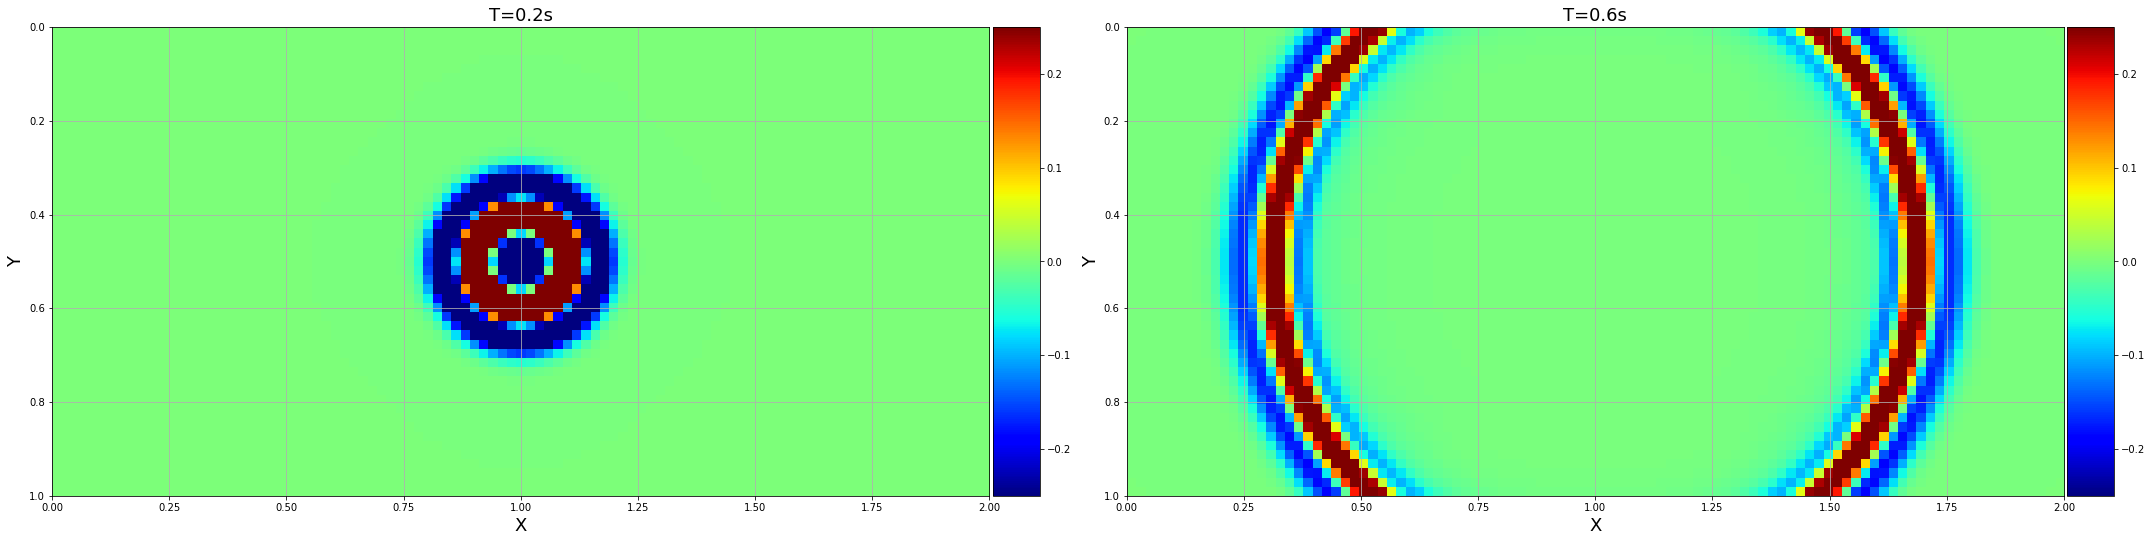

In [7]:
################## Load and plot training data ##################
import h5py
hdf_fname="/mount/workspace_test/temp/mtc-repo/examples/we-fwd-2d-cv-snapshots/data_fd_wave-2d-snapshots-n10-ti-0.2-tf-0.6.hdf5"
f = h5py.File(hdf_fname, "r")
X_data_load = np.reshape(f['x'],(n_snap, nx_train, ny_train))
Y_data_load = np.reshape(f['y'],(n_snap, nx_train, ny_train))
T_data_load = np.reshape(f['t'],(n_snap, nx_train, ny_train))
P_data_load = np.reshape(f['pressure'],(n_snap, nx_train, ny_train))

print("X_data_load shape: ", X_data_load.shape)
print("Y_data_load shape: ", Y_data_load.shape)
print("T_data_load shape: ", T_data_load.shape)
print("P_data_load shape: ", P_data_load.shape)

#### Plot results for QC #### 
fig, axs = plt.subplots(1, 2, figsize=(30, 30))
img0 = axs[0].imshow(P_data_load[0,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Y', fontsize=18)
axs[0].set_title('T='+str(T_data_load[0,0,0])+'s', fontsize=18)
axs[0].grid()
plt.tight_layout()

img0 = axs[1].imshow(P_data_load[n_snap-1,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Y', fontsize=18)
axs[1].set_title('T='+str(T_data_load[n_snap-1,0,0])+'s', fontsize=18)
axs[1].grid()
plt.tight_layout()


## PINN solution
1. Load solution only for data points used for training

In [8]:
# Import inferencer
import training.stage2.infer as infer_stage1

# Display information on inferencer
infer_stage1.info

u1 = infer_stage1.infer(x=X_data, y=Y_data, t=T_data)['pressure']
u1 = u1.reshape(X_data.shape)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/modulus/modulus/dataset/dataset.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:200.)
  key: torch.as_tensor(value, dtype=tf_dt, device=device)


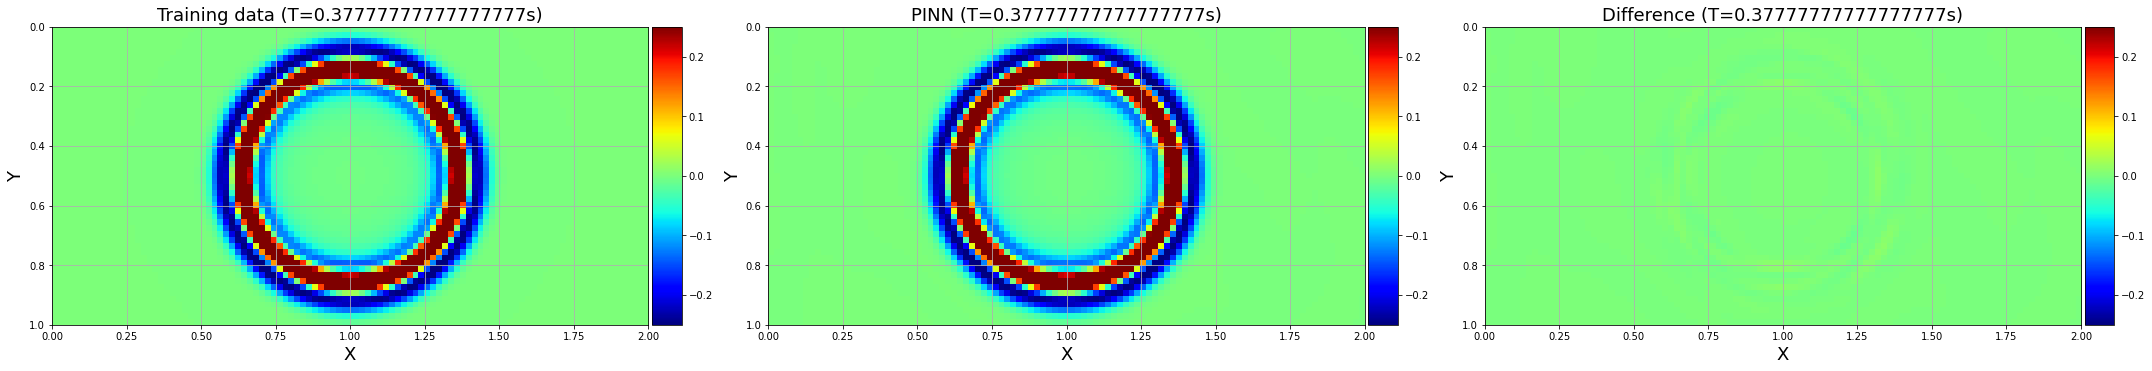

In [9]:
#### Plot results for QC #### 
isnap = 4
t_inference = rec_time[isnap]
fig, axs = plt.subplots(1, 3, figsize=(30, 30))

img0 = axs[0].imshow(P_data_load[isnap,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Y', fontsize=18)
axs[0].set_title('Training data (T='+str(t_inference)+'s)', fontsize=18)
axs[0].grid()
plt.tight_layout()

img0 = axs[1].imshow(u1[isnap,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Y', fontsize=18)
axs[1].set_title('PINN (T='+str(t_inference)+'s)', fontsize=18)
axs[1].grid()
plt.tight_layout()

img0 = axs[2].imshow(u1[isnap,:,:].T-P_data_load[isnap,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Y', fontsize=18)
axs[2].set_title('Difference (T='+str(t_inference)+'s)', fontsize=18)
axs[2].grid()
plt.tight_layout()

2. Load solution only for data points not used for training

In [10]:
## Inferencer for more snapshots (that are not in the training dataset)

# Choose time slices to record
n_snap_infer = 20
t_init_infer = 0.2
t_final_infer = 0.8
rec_time_infer = np.linspace(t_init_infer, t_final_infer, n_snap_infer)

# Allocate arrays for PINN
T_data_infer = np.zeros((n_snap_infer, nx_infer, ny_infer))
X_data_infer = np.zeros((n_snap_infer, nx_infer, ny_infer))
Y_data_infer = np.zeros((n_snap_infer, nx_infer, ny_infer))
P_data_infer = np.zeros((n_snap_infer, nx_infer, ny_infer))

# Generate data
for it in range(n_snap_infer):
    index = np.argmin(abs(rec_time_infer[it]-t))
    P_data_infer[it,:,:] = P_sub[index,:,:]
    T_data_infer[it,:,:] = T_sub[index,:,:]
    X_data_infer[it,:,:] = X_sub[index,:,:]
    Y_data_infer[it,:,:] = Y_sub[index,:,:]

u1 = infer_stage1.infer(x=X_data_infer, y=Y_data_infer, t=T_data_infer)['pressure']
u1 = u1.reshape(X_data_infer.shape)

print("shape u1: ", u1.shape)
print("shape P_data_infer: ", P_data_infer.shape)

shape u1:  (20, 101, 51)
shape P_data_infer:  (20, 101, 51)


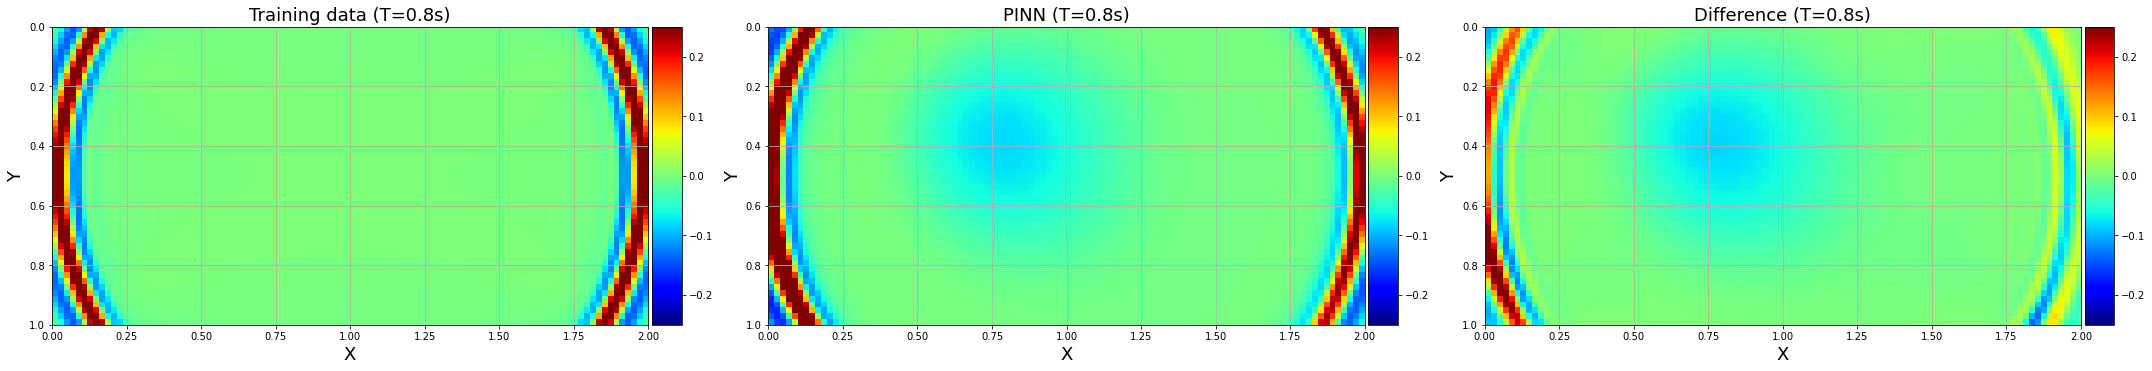

In [20]:
#### Plot results for QC #### 
isnap = 19
t_inference = rec_time_infer[isnap]
fig, axs = plt.subplots(1, 3, figsize=(30, 30))

img0 = axs[0].imshow(P_data_infer[isnap,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Y', fontsize=18)
axs[0].set_title('Training data (T='+str(round(t_inference,2))+'s)', fontsize=18)
axs[0].grid()
plt.tight_layout()

img0 = axs[1].imshow(u1[isnap,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Y', fontsize=18)
axs[1].set_title('PINN (T='+str(round(t_inference,2))+'s)', fontsize=18)
axs[1].grid()
plt.tight_layout()

img0 = axs[2].imshow(u1[isnap,:,:].T-P_data_infer[isnap,:,:].T, cmap='jet', vmin=p_min, vmax=p_max, extent=(xmin, xmax, ymin, ymax))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Y', fontsize=18)
axs[2].set_title('Difference (T='+str(round(t_inference,2))+'s)', fontsize=18)
axs[2].grid()
plt.tight_layout()

# Save figure
name_fig = "we-fwd-2d-cv-snapshots-fd-pressure-t"+str(round(t_inference,2))+".png"
plt.savefig(name_fig)
